In [2]:
import numpy as np 
import pandas as pd 
import json
import bq_helper
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import plotly.graph_objs as go

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
import time

from matplotlib import rcParams

In [3]:
# https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

def load_df(csv_path='../input/train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'], load_all=False):
    if not load_all:
        df = pd.read_csv(csv_path, 
                         converters={column: json.loads for column in JSON_COLUMNS}, 
                         dtype={'fullVisitorId': 'str'}, nrows=300000)
    else:
        df = pd.read_csv(csv_path, 
                         converters={column: json.loads for column in JSON_COLUMNS}, 
                         dtype={'fullVisitorId': 'str'})
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

In [18]:
# Loading and preprocessing
#%%time
train = load_df("all/train_v2.csv")

In [19]:
%%time
subm = pd.read_csv("all/sample_submission_v2.csv", dtype={'fullVisitorId': 'str'})
print(subm['fullVisitorId'].nunique())

296530
Wall time: 5.39 s


In [202]:
# Saving to file
#train.to_csv('all/prcd_train_v2_300k.csv', sep=';')

In [203]:
# Loading preprocessed file
#%%time
#train = pd.read_csv('all/prcd_train_v2_300k.csv', dtype={'fullVisitorId': 'str'},sep = ";", index_col = 0) 
#, low_memory=False)

C:\Users\Nuclear\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.



In [204]:
#train.info()

In [ ]:
%%time
test = load_df("all/test_v2.csv")

In [11]:
test['fullVisitorId'].nunique()

229147

In [206]:
#%%time
#test = pd.read_csv('all/prcd_test_v2.csv', dtype={'fullVisitorId': 'str'},sep = ";", index_col = 0) #, low_memory=False)

Wall time: 7min 19s


In [207]:
# Saving to file
#test.to_csv('all/prcd_test_v2.csv', sep=';')

In [211]:
test["fullVisitorId"].nunique()


In [12]:
# One line submission
"""
__import__('pandas').read_csv('../input/test_v2.csv', usecols=[4,8], dtype={'fullVisitorId': 'str'},
converters={'totals': lambda t: float(dict(eval(t))['transactionRevenue']) if 'transactionRevenue' in t else 0}).
groupby(['fullVisitorId'])['totals'].sum().to_frame(name='PredictedLogRevenue').apply(__import__('numpy').
log1p).to_csv('sub.csv')
"""

"\n__import__('pandas').read_csv('../input/test_v2.csv', usecols=[4,8], dtype={'fullVisitorId': 'str'},\nconverters={'totals': lambda t: float(dict(eval(t))['transactionRevenue']) if 'transactionRevenue' in t else 0}).\ngroupby(['fullVisitorId'])['totals'].sum().to_frame(name='PredictedLogRevenue').apply(__import__('numpy').\nlog1p).to_csv('sub.csv')\n"

In [13]:
#train.head(3).T

In [14]:
# Some data processing
train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # Fill with zero inplace
test['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
train['trafficSource.isTrueDirect'].fillna(False, inplace=True)
test['trafficSource.isTrueDirect'].fillna(False, inplace=True)
# Date to datetime_format
train['date'] = pd.to_datetime(train['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
test['date'] = pd.to_datetime(test['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))

In [15]:
# Save changed files
# Cleaning
# Categorical to numerical data
# Heatmap - OK
# Scatterplot matrix
# How to investigate data inside json table?
# crosstab
# one-hot-vectors
# new crossed features
# product feature in hits field

# If we build on this thought (one value feature), 
# it is reasonable to say that features with low variance
# are worse than those with high variance.

### Data exploration

In [16]:
# json to pandas 
'''
from copy import deepcopy # full copy of an instance
train_ =  deepcopy(train.head(3))
print(train_)

import ast
train_["hits"] = train_["hits"].apply(ast.literal_eval)

pd.DataFrame(train_['hits'][0])['appInfo'][0]
'''

# product in hits can be an interesting feature

'\nfrom copy import deepcopy # full copy of an instance\ntrain_ =  deepcopy(train.head(3))\nprint(train_)\n\nimport ast\ntrain_["hits"] = train_["hits"].apply(ast.literal_eval)\n\npd.DataFrame(train_[\'hits\'][0])[\'appInfo\'][0]\n'

Some of columns aren't available in this dataset, let's drop them and some have 1 unique value only.

In [17]:
cols_to_drop = [col for col in train.columns if train[col].nunique(dropna=False) == 1]
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop([col for col in cols_to_drop if col in test.columns], axis=1, inplace=True)

In [18]:
print('Dropped {0} columns.'.format(len(cols_to_drop)))

Dropped 19 columns.


In [19]:
train[['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 4 columns):
visitNumber                  300000 non-null int64
totals.hits                  300000 non-null int64
totals.pageviews             299961 non-null float64
totals.transactionRevenue    3154 non-null float64
dtypes: float64(2), int64(2)
memory usage: 11.4 MB


In [20]:
# converting columns into more reasonable format
for col in ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']:
    train[col] = train[col].astype(float)

In [21]:
train.drop(['customDimensions', 'hits', 'trafficSource.referralPath', 'trafficSource.source', 'totals.totalTransactionRevenue'], axis=1, inplace=True)
test.drop(['customDimensions', 'hits', 'trafficSource.referralPath', 'trafficSource.source', 'totals.totalTransactionRevenue'], axis=1, inplace=True)

In [22]:
train.head().T

,0,1,2,3,4
channelGrouping,Organic Search,Referral,Direct,Organic Search,Organic Search
date,2017-10-16 00:00:00,2017-10-16 00:00:00,2017-10-16 00:00:00,2017-10-16 00:00:00,2017-10-16 00:00:00
fullVisitorId,3162355547410993243,8934116514970143966,7992466427990357681,9075655783635761930,6960673291025684308
visitId,1508198450,1508176307,1508201613,1508169851,1508190552
visitNumber,1,6,1,1,1
visitStartTime,1508198450,1508176307,1508201613,1508169851,1508190552
device.browser,Firefox,Chrome,Chrome,Chrome,Chrome
device.deviceCategory,desktop,desktop,mobile,desktop,desktop
device.isMobile,False,False,True,False,False
device.operatingSystem,Windows,Chrome OS,Android,Windows,Windows


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 36 columns):
channelGrouping                                 300000 non-null object
date                                            300000 non-null datetime64[ns]
fullVisitorId                                   300000 non-null object
visitId                                         300000 non-null int64
visitNumber                                     300000 non-null float64
visitStartTime                                  300000 non-null int64
device.browser                                  300000 non-null object
device.deviceCategory                           300000 non-null object
device.isMobile                                 300000 non-null bool
device.operatingSystem                          300000 non-null object
geoNetwork.city                                 300000 non-null object
geoNetwork.continent                            300000 non-null object
geoNetwork.country              

In [198]:
test.groupby("fullVisitorId").count().sum()

channelGrouping                                 300000
date                                            300000
visitId                                         300000
visitNumber                                     300000
visitStartTime                                  300000
device.browser                                  300000
device.deviceCategory                           300000
device.isMobile                                 300000
device.operatingSystem                          300000
geoNetwork.city                                 300000
geoNetwork.continent                            300000
geoNetwork.country                              300000
geoNetwork.metro                                300000
geoNetwork.networkDomain                        300000
geoNetwork.region                               300000
geoNetwork.subContinent                         300000
totals.bounces                                  300000
totals.hits                                     300000
totals.new

In [24]:
# Some simple statistics
for col in train.columns:
    if train[col].isnull().sum() > 0:
        rate = train[col].isnull().sum() * 100 / train.shape[0]
        print('Column {0} has {1:.4f}% missing values.'.format(col,rate))
    if train[col].dtype == 'object':
        if (train[col] == 'not available in demo dataset').sum() > 0:
            rate = (train[col] == 'not available in demo dataset').sum() * 100 / train.shape[0]
            print('Column {0} has {1:.4f}% values not available in dataset.'.format(col, rate))

Column geoNetwork.city has 54.5520% values not available in dataset.
Column geoNetwork.metro has 54.5520% values not available in dataset.
Column geoNetwork.region has 54.5520% values not available in dataset.
Column totals.bounces has 48.4557% missing values.
Column totals.newVisits has 22.8260% missing values.
Column totals.pageviews has 0.0130% missing values.
Column totals.sessionQualityDim has 53.3087% missing values.
Column totals.timeOnSite has 51.7020% missing values.
Column totals.transactionRevenue has 98.9487% missing values.
Column totals.transactions has 98.9443% missing values.
Column trafficSource.adContent has 96.0480% missing values.
Column trafficSource.adwordsClickInfo.adNetworkType has 95.3547% missing values.
Column trafficSource.adwordsClickInfo.gclId has 95.3353% missing values.
Column trafficSource.adwordsClickInfo.page has 95.3547% missing values.
Column trafficSource.adwordsClickInfo.slot has 95.3547% missing values.
Column trafficSource.campaignCode has 99.99

# Feature analysis

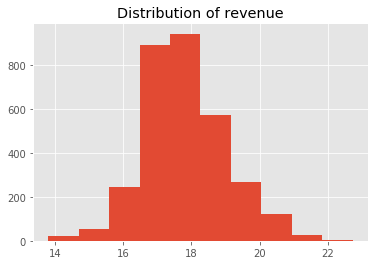

In [25]:
plt.hist(np.log1p(train.loc[train['totals.transactionRevenue'].isna() == False, 'totals.transactionRevenue']));
plt.title('Distribution of revenue');

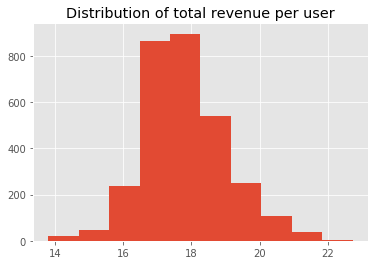

In [26]:
grouped = train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
grouped = grouped.loc[grouped['totals.transactionRevenue'].isna() == False] # isna -> missing values
plt.hist(np.log(grouped.loc[grouped['totals.transactionRevenue'] > 0, 'totals.transactionRevenue']));
plt.title('Distribution of total revenue per user');

In [27]:
counts = train.loc[train['totals.transactionRevenue'] > 0, 'fullVisitorId'].value_counts()
print('There are {0} paying users ({1} total) in train data.'.format(len(counts), train['fullVisitorId'].nunique()))
print('{0} users ({1:.4f}% of paying) have 1 paid transaction.'.format(counts == 1, 100 * np.sum(counts == 1) / len(counts)))
print('{0} users ({1:.4f}% of paying) have 2 paid transaction.'.format(np.sum(counts == 2), 100 * np.sum(counts == 2) / len(counts)))
print('')
print('Count of non-zero transactions per user:')
counts.head(10)

There are 3004 paying users (262777 total) in train data.
7813149961404844386    False
7311242886083854158    False
8197879643797712877    False
6760732402251466726    False
6476783278979674523    False
4984366501121503466    False
2402527199731150932    False
4792411607866172207    False
4358918846442674981    False
6820200829240883942    False
7725691113815221366    False
9936682614369895259    False
2348681849763325965    False
4808974885561715322    False
3857043812510146001    False
7420300501523012460    False
4671049020900082348    False
6010250598436085923    False
0608915197735218105    False
1759779356678951325    False
5184801136217183810    False
584412282919066406     False
6147396474895233852    False
2920950269946903107    False
1735639359262605484    False
156905236318704928     False
4267209767907289538    False
0290663072707523580    False
9029794295932939024    False
5370755895090744456    False
                       ...  
7116240832915419008     True
42971511243114

7813149961404844386    9
7311242886083854158    6
8197879643797712877    5
6760732402251466726    5
6476783278979674523    4
4984366501121503466    4
2402527199731150932    4
4792411607866172207    4
4358918846442674981    3
6820200829240883942    3
Name: fullVisitorId, dtype: int64

### Counts of buying customers distribution

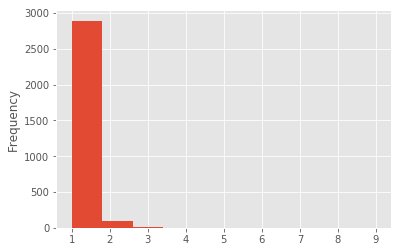

In [28]:
counts.plot(kind = 'hist')

In [29]:
max(counts)

9

In [30]:
for i in range(1,max(counts)+1):
    print("#: {0} has {1:.4f}% counts".format(i, np.sum(counts == i) * 100/len(counts)))

#: 1 has 96.2383% counts
#: 2 has 3.0959% counts
#: 3 has 0.3995% counts
#: 4 has 0.1332% counts
#: 5 has 0.0666% counts
#: 6 has 0.0333% counts
#: 7 has 0.0000% counts
#: 8 has 0.0000% counts
#: 9 has 0.0333% counts


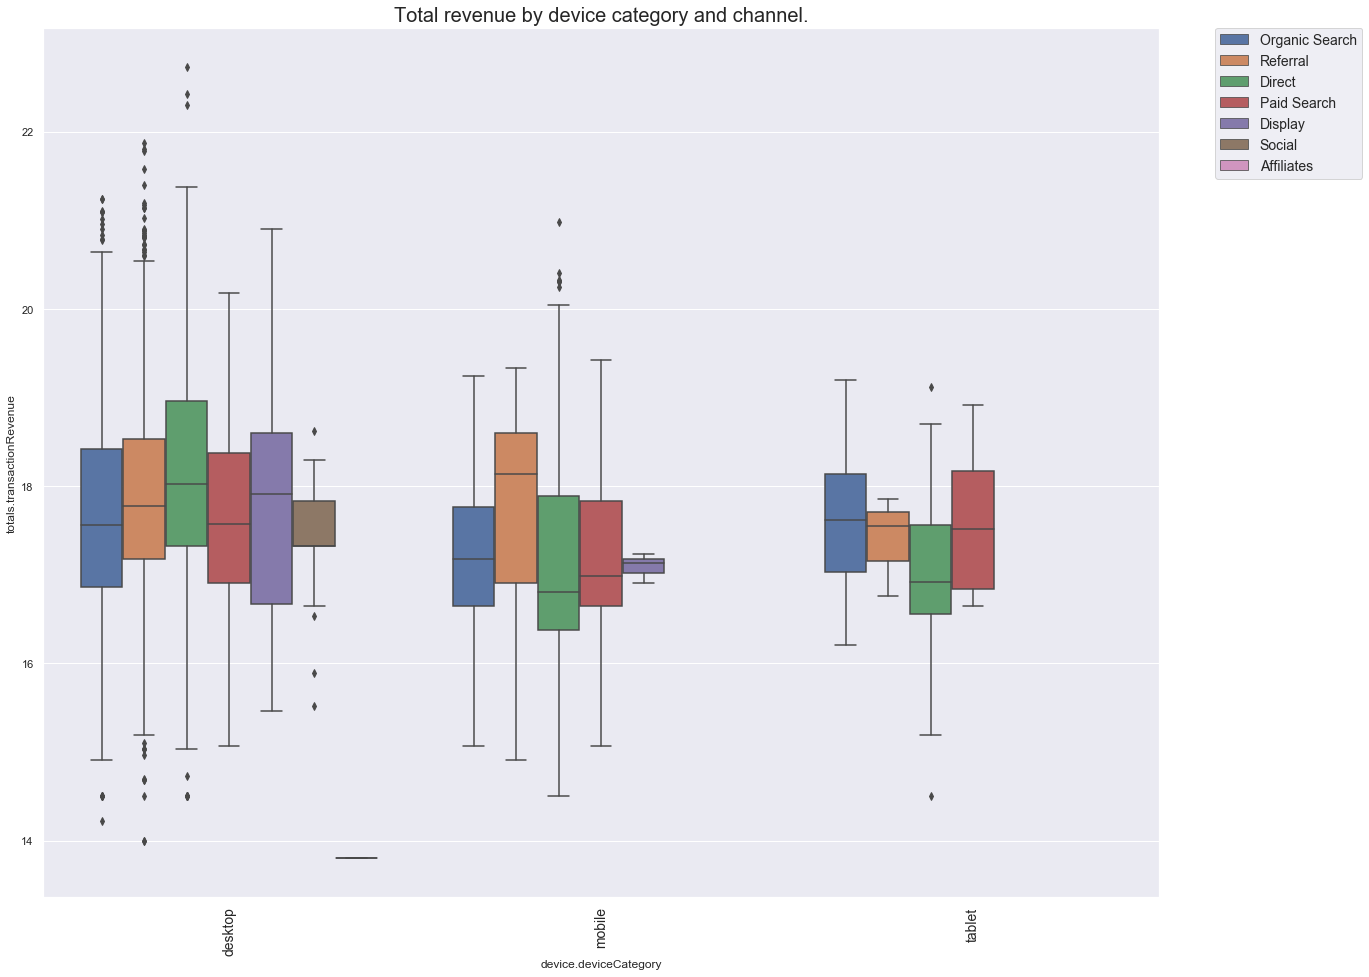

In [31]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0)
target = train['totals.transactionRevenue']
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'])
sns.set(rc={'figure.figsize':(20, 16)})
train_ = train.loc[train['totals.transactionRevenue'] > 0.0]
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping",  data=train_)
plt.title("Total revenue by device category and channel.", size = 20);
plt.xticks(rotation='vertical', fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 14)
plt.show()

### Weekly patterns

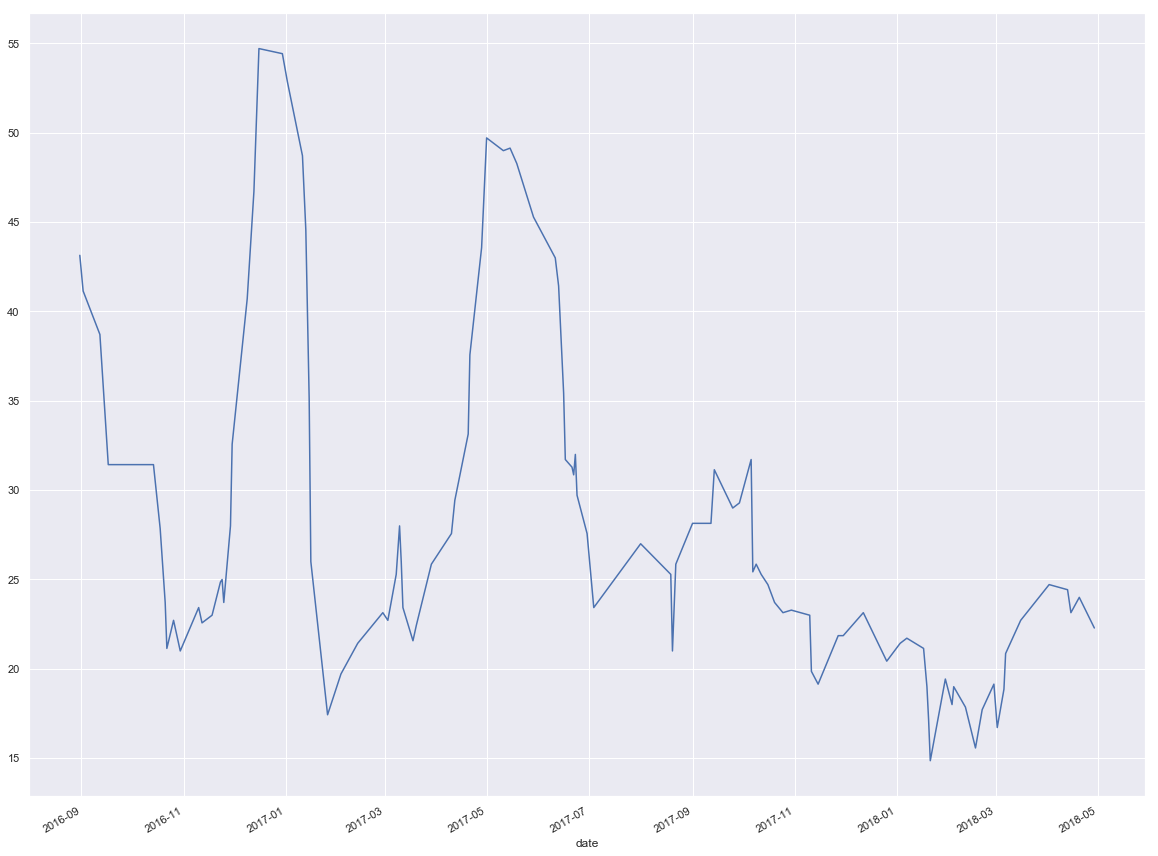

In [32]:
# Paying users
trans_by_date = train[train['totals.transactionRevenue']>0].groupby('date').size()
trans_by_date.rolling(window=7).mean().plot()
#non-zero transaction pattern

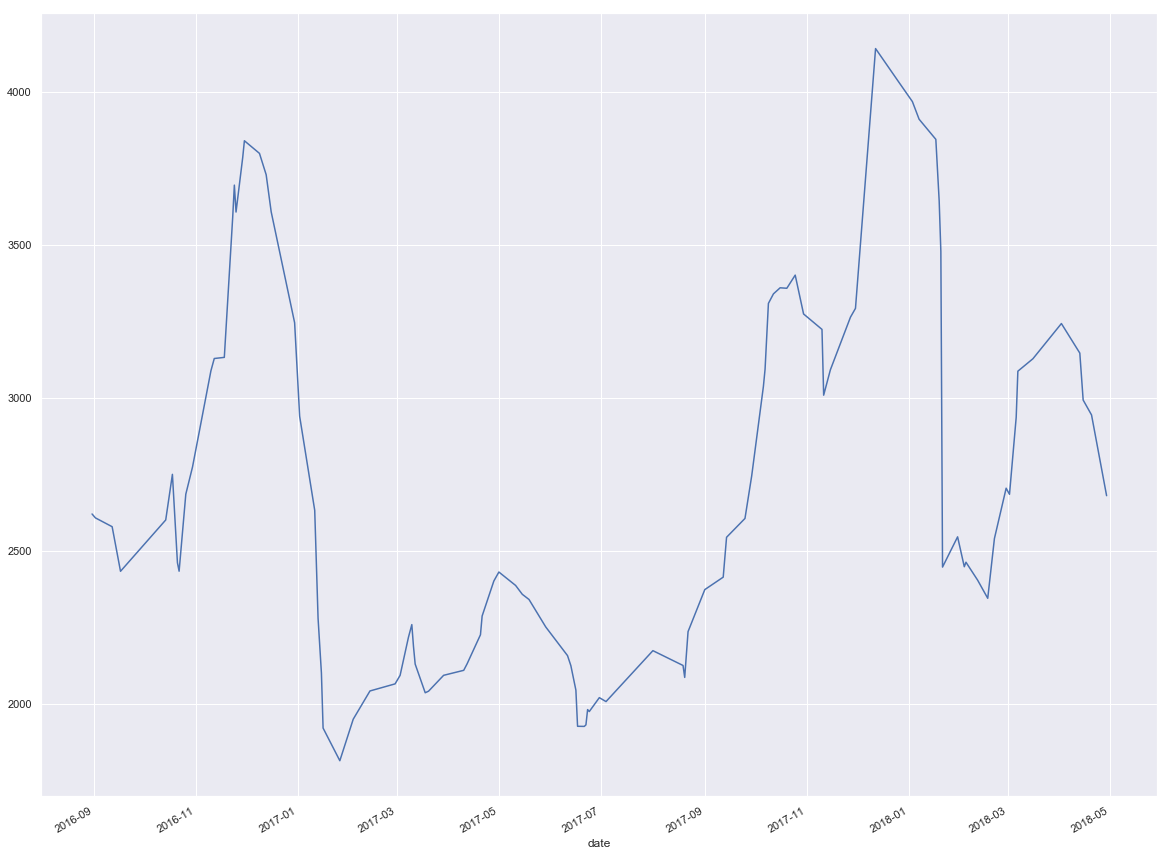

In [33]:
# All users
trans_by_date = train.groupby('date').size()
trans_by_date.rolling(window=7).mean().plot()

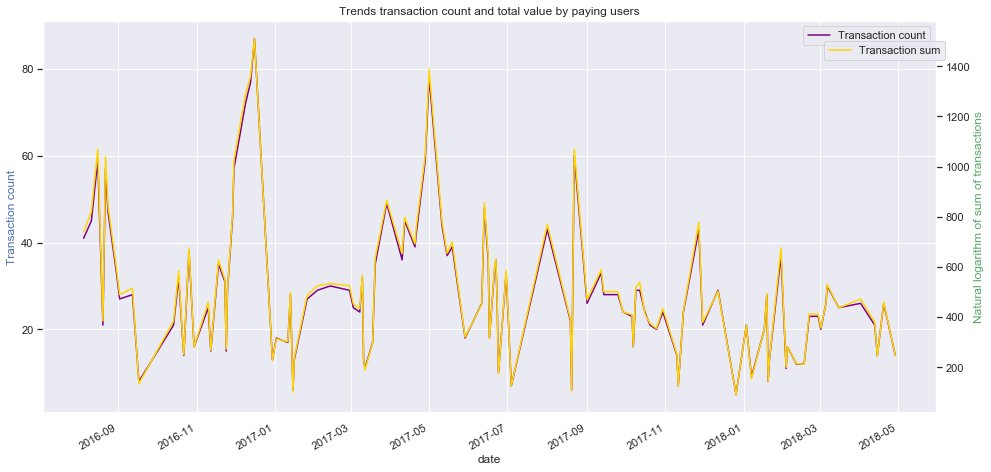

In [34]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends transaction count and total value by paying users")
train_.groupby(['date'])['totals.transactionRevenue'].count().plot(color='purple')
ax1.set_ylabel('Transaction count', color='b')
plt.legend(['Transaction count'])
ax2 = ax1.twinx()
train_.groupby(['date'])['totals.transactionRevenue'].sum().plot(color='gold')
ax2.set_ylabel('Natural logarithm of sum of transactions', color='g')
plt.legend(['Transaction sum'], loc=(0.875, 0.9))
plt.grid(False)

In [35]:
print(f'First date in train set is {train["date"].min()}. Last date in train set is {train["date"].max()}.')
print(f'First date in test set is {test["date"].min()}. Last date in test set is {test["date"].max()}.')

SyntaxError: invalid syntax (<ipython-input-35-60547ef4f0aa>, line 1)

### Devices test

In [40]:
#device.browser, device.deviceCategory, device.isMobile, device.operatingSystem 

In [106]:
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [109]:
#All users' devices

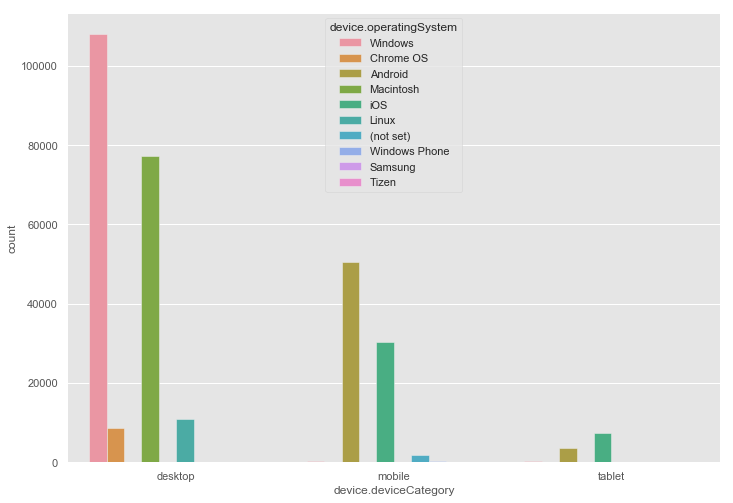

In [107]:
top10_os = train.groupby("device.operatingSystem").count().\
sort_values(by=['fullVisitorId'], ascending=False).head(10).reset_index()['device.operatingSystem'].values

#sns.boxplot(x='device.deviceCategory', y='visitNumber', hue = 'device.operatingSystem',\
#            data=train.loc[train['device.operatingSystem'].isin(top10_os)]);

sns.countplot(x='device.deviceCategory', hue = 'device.operatingSystem',\
            data=train.loc[train['device.operatingSystem'].isin(top10_os)]);

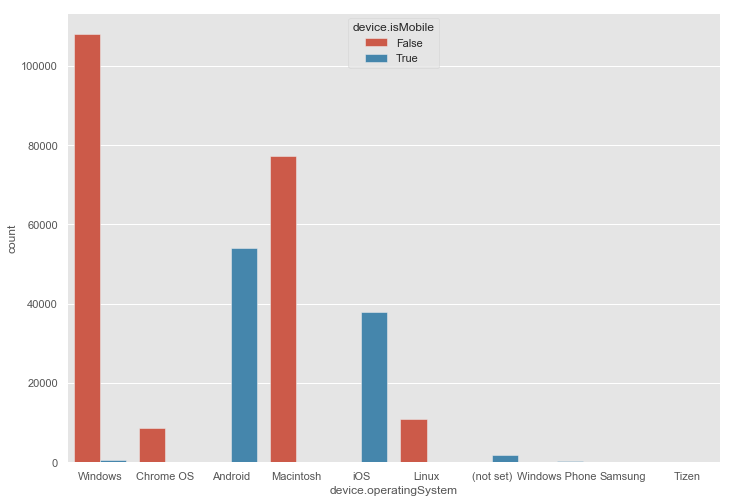

In [108]:
sns.countplot(x='device.operatingSystem',
              hue='device.isMobile',
              data=train.loc[train['device.operatingSystem'].\
                             isin(top10_os)]);

### Feature engineering

In [111]:
# time based
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekday'] = train['date'].dt.weekday
train['weekofyear'] = train['date'].dt.weekofyear

train['month_unique_user_count'] = train.groupby('month')['fullVisitorId'].transform('nunique')
train['day_unique_user_count'] = train.groupby('day')['fullVisitorId'].transform('nunique')
train['weekday_unique_user_count'] = train.groupby('weekday')['fullVisitorId'].transform('nunique')
train['weekofyear_unique_user_count'] = train.groupby('weekofyear')['fullVisitorId'].transform('nunique')

test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday
test['weekofyear'] = test['date'].dt.weekofyear

test['month_unique_user_count'] = test.groupby('month')['fullVisitorId'].transform('nunique')
test['day_unique_user_count'] = test.groupby('day')['fullVisitorId'].transform('nunique')
test['weekday_unique_user_count'] = test.groupby('weekday')['fullVisitorId'].transform('nunique')
test['weekofyear_unique_user_count'] = test.groupby('weekofyear')['fullVisitorId'].transform('nunique')

In [112]:
# device based

train['browser_category'] = train['device.browser'] + '_' + train['device.deviceCategory']
train['browser_operatingSystem'] = train['device.browser'] + '_' + train['device.operatingSystem']

test['browser_category'] = test['device.browser'] + '_' + test['device.deviceCategory']
test['browser_operatingSystem'] = test['device.browser'] + '_' + test['device.operatingSystem']

In [113]:
train['visitNumber'] = np.log1p(train['visitNumber'])
test['visitNumber'] = np.log1p(test['visitNumber'])

train['totals.hits'] = np.log1p(train['totals.hits'])
test['totals.hits'] = np.log1p(test['totals.hits'].astype(int))

train['totals.pageviews'] = np.log1p(train['totals.pageviews'].fillna(0))
test['totals.pageviews'] = np.log1p(test['totals.pageviews'].astype(float).fillna(0))

train['sum_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
train['count_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
train['mean_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
train['sum_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
train['count_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
train['mean_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

test['sum_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
test['count_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
test['mean_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
test['sum_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
test['count_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
test['mean_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

train['mean_hits_per_day'] = train.groupby(['day'])['totals.hits'].transform('mean')
train['sum_hits_per_day'] = train.groupby(['day'])['totals.hits'].transform('sum')
test['mean_hits_per_day'] = test.groupby(['day'])['totals.hits'].transform('mean')
test['sum_hits_per_day'] = test.groupby(['day'])['totals.hits'].transform('sum')

In [114]:
train['sum_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
train['count_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
train['mean_pageviews_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')

train['sum_pageviews_per_region'] = train.groupby('geoNetwork.region')['totals.pageviews'].transform('sum')
train['count_pageviews_per_region'] = train.groupby('geoNetwork.region')['totals.pageviews'].transform('count')
train['mean_pageviews_per_region'] = train.groupby('geoNetwork.region')['totals.pageviews'].transform('mean')

test['sum_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
test['count_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
test['mean_pageviews_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')

test['sum_pageviews_per_region'] = test.groupby('geoNetwork.region')['totals.pageviews'].transform('sum')
test['count_pageviews_per_region'] = test.groupby('geoNetwork.region')['totals.pageviews'].transform('count')
test['mean_pageviews_per_region'] = test.groupby('geoNetwork.region')['totals.pageviews'].transform('mean')

In [115]:
train['sum_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
train['count_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
train['mean_hits_per_network_domain'] = train.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

train['sum_hits_per_region'] = train.groupby('geoNetwork.region')['totals.hits'].transform('sum')
train['count_hits_per_region'] = train.groupby('geoNetwork.region')['totals.hits'].transform('count')
train['mean_hits_per_region'] = train.groupby('geoNetwork.region')['totals.hits'].transform('mean')

train['sum_hits_per_country'] = train.groupby('geoNetwork.country')['totals.hits'].transform('sum')
train['count_hits_per_country'] = train.groupby('geoNetwork.country')['totals.hits'].transform('count')
train['mean_hits_per_country'] = train.groupby('geoNetwork.country')['totals.hits'].transform('mean')

test['sum_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
test['count_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
test['mean_hits_per_network_domain'] = test.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')

test['sum_hits_per_region'] = test.groupby('geoNetwork.region')['totals.hits'].transform('sum')
test['count_hits_per_region'] = test.groupby('geoNetwork.region')['totals.hits'].transform('count')
test['mean_hits_per_region'] = test.groupby('geoNetwork.region')['totals.hits'].transform('mean')

test['sum_hits_per_country'] = test.groupby('geoNetwork.country')['totals.hits'].transform('sum')
test['count_hits_per_country'] = test.groupby('geoNetwork.country')['totals.hits'].transform('count')
test['mean_hits_per_country'] = test.groupby('geoNetwork.country')['totals.hits'].transform('mean')

In [116]:
train['user_pageviews_sum'] = train.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
train['user_hits_sum'] = train.groupby('fullVisitorId')['totals.hits'].transform('sum')
test['user_pageviews_sum'] = test.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
test['user_hits_sum'] = test.groupby('fullVisitorId')['totals.hits'].transform('sum')

train['user_pageviews_count'] = train.groupby('fullVisitorId')['totals.pageviews'].transform('count')
train['user_hits_count'] = train.groupby('fullVisitorId')['totals.hits'].transform('count')
test['user_pageviews_count'] = test.groupby('fullVisitorId')['totals.pageviews'].transform('count')
test['user_hits_count'] = test.groupby('fullVisitorId')['totals.hits'].transform('count')

train['user_pageviews_sum_to_mean'] = train['user_pageviews_sum'] / train['user_pageviews_sum'].mean()
train['user_hits_sum_to_mean'] = train['user_hits_sum'] / train['user_hits_sum'].mean()
test['user_pageviews_sum_to_mean'] = test['user_pageviews_sum'] / test['user_pageviews_sum'].mean()
test['user_hits_sum_to_mean'] = test['user_hits_sum'] / test['user_hits_sum'].mean()

In [117]:
train['user_pageviews_to_region'] = train['user_pageviews_sum'] / train['mean_pageviews_per_region']
train['user_hits_to_region'] = train['user_hits_sum'] / train['mean_hits_per_region']

test['user_pageviews_to_region'] = test['user_pageviews_sum'] / test['mean_pageviews_per_region']
test['user_hits_to_region'] = test['user_hits_sum'] / test['mean_hits_per_region']

In [118]:
# There are a lot more features introduced by that guy 
num_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'month_unique_user_count', 'day_unique_user_count', 'mean_hits_per_day'
           'sum_pageviews_per_network_domain', 'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'sum_hits_per_region',
           'sum_hits_per_day', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain', 'weekday_unique_user_count',
           'sum_pageviews_per_region', 'count_pageviews_per_region', 'mean_pageviews_per_region', 'user_pageviews_count', 'user_hits_count',
           'count_hits_per_region', 'mean_hits_per_region', 'user_pageviews_sum', 'user_hits_sum', 'user_pageviews_sum_to_mean',
            'user_hits_sum_to_mean', 'user_pageviews_to_region', 'user_hits_to_region', 'mean_pageviews_per_network_domain',
           'mean_hits_per_network_domain']
no_use = ["visitNumber", "date", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 'totals.transactionRevenue', 'trafficSource.referralPath']
cat_cols = [col for col in train.columns if col not in num_cols and col not in no_use]

In [119]:
len(cat_cols)

40

In [120]:
for col in cat_cols:
    if col != 'trafficSource.campaignCode':
        print(col)
        lbl = LabelEncoder()
        lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
        train[col] = lbl.transform(list(train[col].values.astype('str')))
        test[col] = lbl.transform(list(test[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.isMobile
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
totals.bounces
totals.newVisits
totals.sessionQualityDim
totals.timeOnSite
totals.transactions
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.isTrueDirect
trafficSource.keyword
trafficSource.medium
browser_category
browser_operatingSystem
month
day
weekday
weekofyear
weekofyear_unique_user_count
sum_pageviews_per_network_domain
mean_hits_per_day
sum_hits_per_country
count_hits_per_country
mean_hits_per_country


In [186]:
no_use.append('trafficSource.campaignCode')
train = train.sort_values('date')


add_col_to_drop = ["count_hits_per_network_domain", "count_hits_per_region",
                   "count_pageviews_per_region","mean_hits_per_region",
                   "trafficSource.adwordsClickInfo.adNetworkType",
                   "trafficSource.adwordsClickInfo.gclId",
                   "trafficSource.adwordsClickInfo.isVideoAd",
                   "trafficSource.adwordsClickInfo.page", "browser_category",
                   "browser_operatingSystem",
                   "user_pageviews_count", 
                   "user_hits_count", "user_pageviews_sum_to_mean",
                   "user_hits_sum_to_mean", "user_pageviews_to_region", 
                   "user_hits_to_region", "sum_hits_per_network_domain",
                   "count_hits_per_network_domain",
                   "mean_hits_per_network_domain", "sum_hits_per_day", 
                   "sum_hits_per_region", "user_pageviews_sum", "totals.pageviews",
                   "device.isMobile"]

X = train.drop([col for col in no_use if col in train.columns]+add_col_to_drop, axis=1)
y = train['totals.transactionRevenue']
X_test = test.drop([col for col in no_use if col in test.columns]+add_col_to_drop, axis=1)
tscv = TimeSeriesSplit(n_splits=5)

In [187]:
# Additionl tricks


In [188]:
# TimeSeriesSplit gives a high variance in scores. Why?

In [189]:
#dir(tscv)

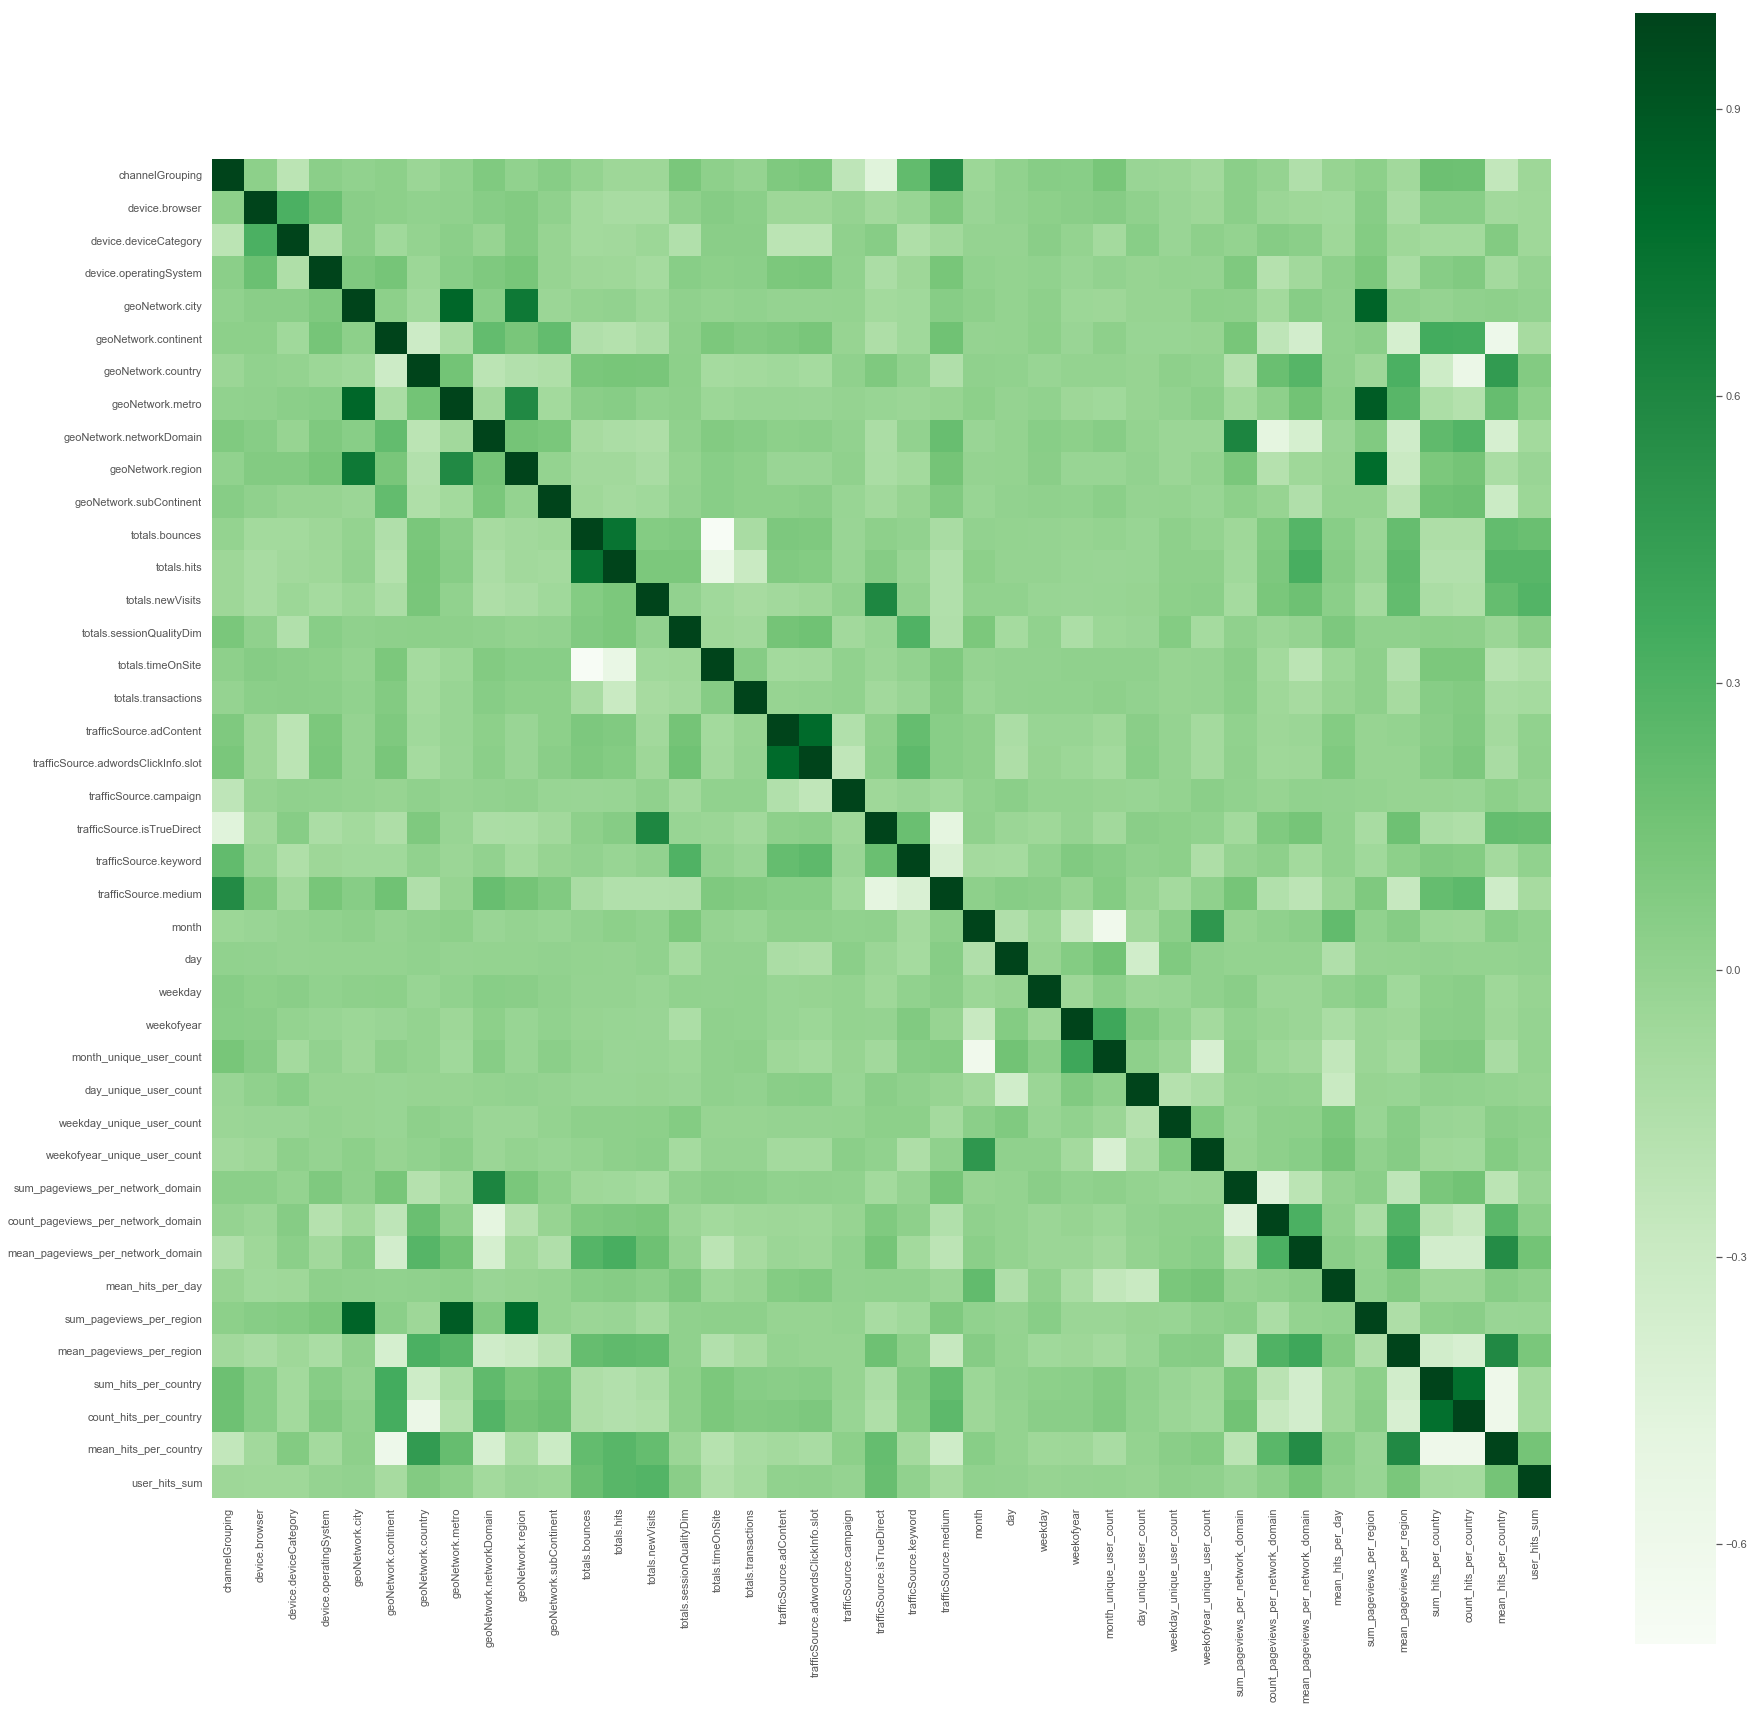

In [185]:
# Only numeric data here!
corrmat = X.corr()
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corrmat, vmax=1, square=True, cmap="Greens");

In [144]:
corrmat.style.background_gradient()

In [190]:
params = {"objective" : "regression", "metric" : "rmse", "max_depth": 9, "min_child_samples": 20, "reg_alpha": 0.2, "reg_lambda": 0.2,
        "num_leaves" : 257, "learning_rate" : 0.005, "subsample" : 0.9, "colsample_bytree" : 0.9, "subsample_freq ": 10}
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)
# Cleaning and defining parameters for LGBM
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)

In [191]:
prediction = np.zeros(test.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
    print('Fold:', fold_n)
    #print(f'Train samples: {len(train_index)}. Valid samples: {len(test_index)}')
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    

    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
            verbose=500, early_stopping_rounds=100)
    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    prediction += y_pred
prediction /= n_fold

Fold: 0
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.216745	valid_1's rmse: 0.427873
[1000]	training's rmse: 0.113344	valid_1's rmse: 0.385573
Early stopping, best iteration is:
[949]	training's rmse: 0.115166	valid_1's rmse: 0.385445
Fold: 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.249326	valid_1's rmse: 0.187017
[1000]	training's rmse: 0.148936	valid_1's rmse: 0.0988331
Early stopping, best iteration is:
[1297]	training's rmse: 0.140436	valid_1's rmse: 0.0964214
Fold: 2
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.2395	valid_1's rmse: 0.273598
[1000]	training's rmse: 0.142782	valid_1's rmse: 0.167933
Early stopping, best iteration is:
[1319]	training's rmse: 0.134005	valid_1's rmse: 0.16662
Fold: 3
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.239546	valid_1's rmse: 0.285608
[1000]	training's rmse: 0.140294	vali

### Important features

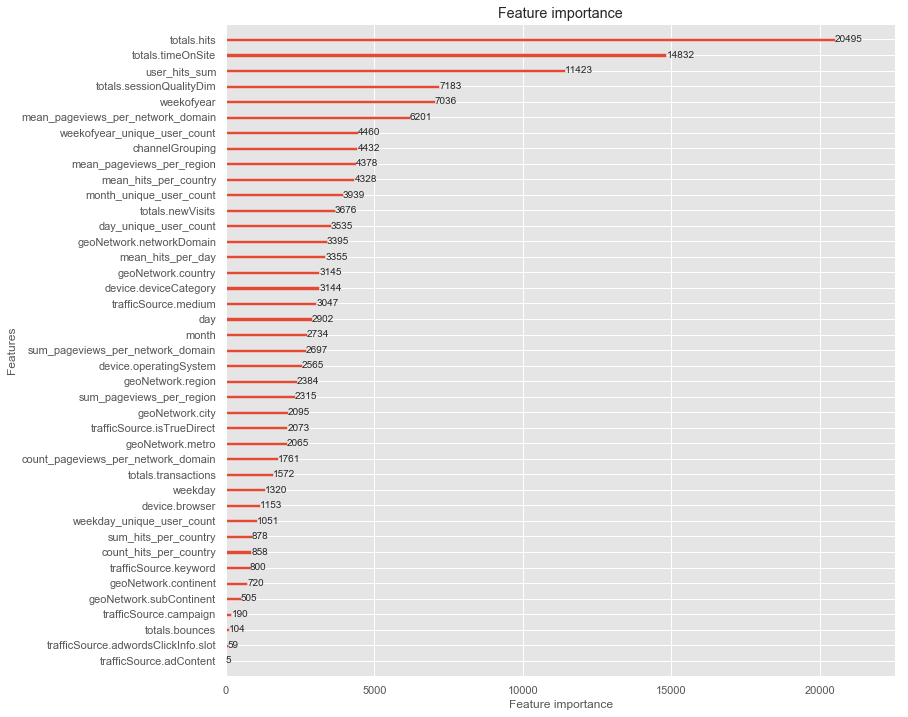

In [192]:
lgb.plot_importance(model, figsize = (12,12));

# Submission

In [131]:
#train.info()

In [132]:
#train.nunique()

In [196]:
test["PredictedLogRevenue"] = prediction
sub = test.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
sub["PredictedLogRevenue"] = np.log1p(sub["PredictedLogRevenue"])
sub["PredictedLogRevenue"] = sub["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
sub["PredictedLogRevenue"] = sub["PredictedLogRevenue"].fillna(0.0)
print(sub.info())
sub.to_csv("lgb.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229147 entries, 0 to 229146
Data columns (total 2 columns):
fullVisitorId          229147 non-null object
PredictedLogRevenue    229147 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.5+ MB
None


### Date splitting

In [97]:
train["Month"] = train["date"].map(lambda x: x.month)

In [100]:
train["Year"] = train["date"].map(lambda x: x.year)
train["Day"] = train["date"].map(lambda x: x.day)
# what about start time?

In [102]:
del trans_by_date

In [108]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

NameError: name 'go' is not defined

In [ ]:
#%config InlineBackend.figure_format = 'png'
#sns.pairplot(train[cat_cols]);

### train date

In [ ]:
num_trans_by_date = train_df.groupby('visitStartDate').size()

In [ ]:
check_date = num_trans_by_date.resample('d').mean()# group data by date. What does mean() do?

In [ ]:
check_date.plot() # number of transactions by date

In [ ]:
# How to divide datetime to year month day time?
# Time between sessions
# box plots for all categories
# hyperplane with trans > 0 and = 0

In [ ]:
#import datetime
#check_date.index[0].date().day

In [ ]:
year = [date.date().year for date in train_df["visitStartDate"]]
month = [date.date().month for date in train_df["visitStartDate"]]
day = [date.date().day for date in train_df["visitStartDate"]]
time = [date.time().hour for date in train_df["visitStartDate"]]

In [ ]:
train_df["Year"] = pd.DataFrame(data={'Year': year})
train_df["Month"] = pd.DataFrame(data={'Month': month})
train_df["Day"] = pd.DataFrame(data={'Day': day})
train_df["Time"] = pd.DataFrame(data={'Time': time})

In [ ]:
sns.countplot(x='Time', data=train_df)

In [97]:
train_df.head(3).T

,0,1,2
channelGrouping,Organic Search,Organic Search,Organic Search
date,20160902,20160902,20160902
fullVisitorId,1131660440785968503,377306020877927890,3895546263509774583
visitId,1472830385,1472880147,1472865386
visitNumber,1,1,1
visitStartTime,1472830385,1472880147,1472865386
browser,Chrome,Firefox,Chrome
deviceCategory,desktop,desktop,desktop
isMobile,False,False,False
operatingSystem,Windows,Macintosh,Windows


### Correlation map

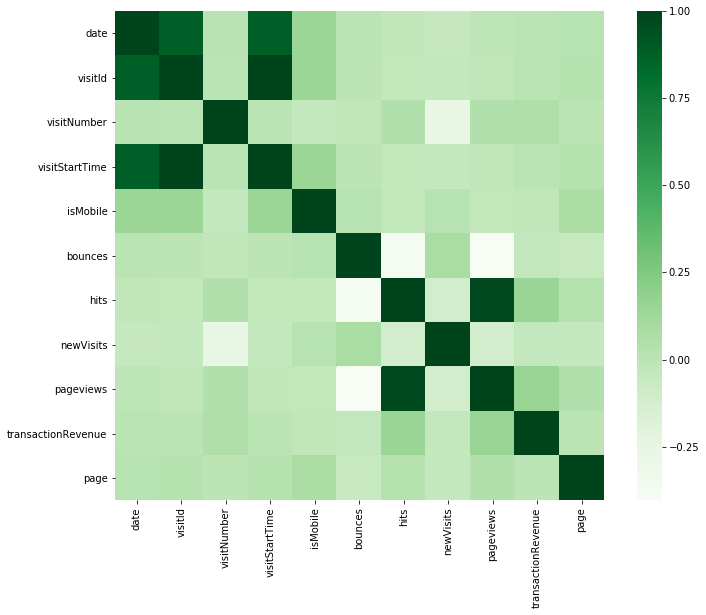

In [9]:
# Only numeric data here!
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, cmap="Greens");

### Cluster map

In [10]:
#sns.clustermap(data_train)

## Object type columns

In [11]:
#Unique elements in each feature column
for column in data_train:
    if data_train[column].dtype == 'object':
        print('In [%s] %s unique elements\n' % (column, len(data_train[column].unique())))

In [channelGrouping] 8 unique elements

In [fullVisitorId] 714167 unique elements

In [sessionId] 902755 unique elements

In [browser] 54 unique elements

In [deviceCategory] 3 unique elements

In [operatingSystem] 20 unique elements

In [city] 649 unique elements

In [continent] 6 unique elements

In [country] 222 unique elements

In [metro] 94 unique elements

In [networkDomain] 28064 unique elements

In [region] 376 unique elements

In [subContinent] 23 unique elements

In [adNetworkType] 3 unique elements

In [gclId] 17775 unique elements

In [isVideoAd] 2 unique elements

In [slot] 3 unique elements

In [targetingCriteria] 2 unique elements

In [campaign] 10 unique elements

In [keyword] 3660 unique elements

In [medium] 7 unique elements

In [source] 380 unique elements

In [isTrueDirect] 2 unique elements

In [referralPath] 1476 unique elements

In [adContent] 45 unique elements

In [campaignCode] 2 unique elements



### Particular cases

In [12]:
# dropping
print(data_train['isVideoAd'].unique())
data_train = data_train.drop(labels = 'isVideoAd', axis = 1) # is it necessary

['0' 'False']


In [13]:
#data_train.loc[data_train['isVideoAd'] == 'False'] = 0
#data_train.loc[data_train['isVideoAd'] == '0'] = 0   
#data_train['isVideoAd'].unique() # drop it !!!

### Hits and pageviews

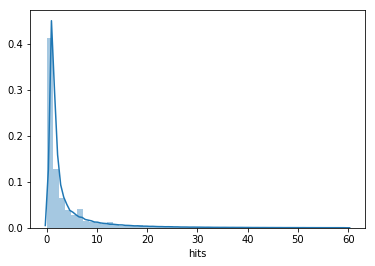

In [14]:
filtered = data_train['hits'][data_train['hits'] <60]
sns.distplot(filtered, hist_kws={"range": [0,60]});

In [15]:
data_train['hits'].describe()

count    903653.000000
mean          4.596538
std           9.641437
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         500.000000
Name: hits, dtype: float64

### transactionRevenue

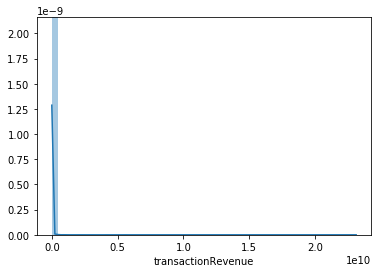

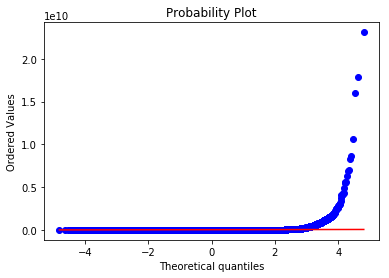

In [19]:
from scipy import stats

sns.distplot(data_train['transactionRevenue']);
fig = plt.figure()
res = stats.probplot(data_train['transactionRevenue'], plot=plt) # ???
plt.show()

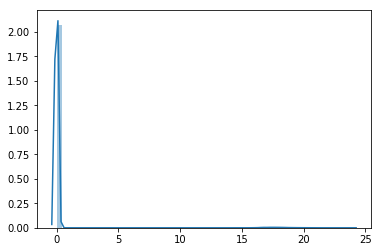

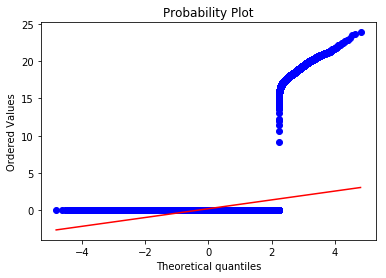

In [22]:
sns.distplot(np.log1p(data_train['transactionRevenue'].values)) # 
fig = plt.figure()
res = stats.probplot(np.log1p(data_train['transactionRevenue'].values), plot=plt) # ???
plt.show()

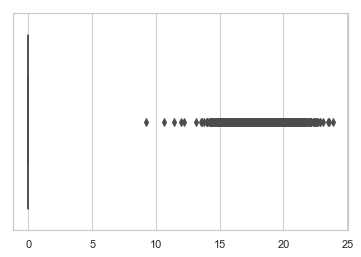

In [28]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=np.log1p(data_train['transactionRevenue'].values))

In [ ]:
#ax = sns.swarmplot(x='transactionRevenue', data=data_train, color=".25")

### pageViews

In [ ]:
data_train['pageviews'].describe()

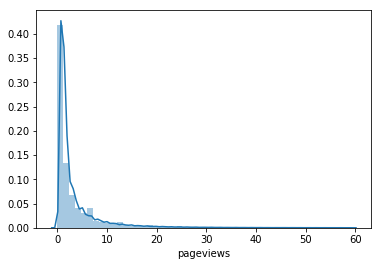

In [43]:
filtered = data_train['pageviews'][data_train['pageviews'] <60]
sns.distplot(filtered, hist_kws={"range": [0,60]});
#sns.distplot(data_train['pageviews'])

### visitNumber

In [48]:
data_train['visitNumber'].describe()

count    903653.000000
mean          2.264897
std           9.283735
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         395.000000
Name: visitNumber, dtype: float64

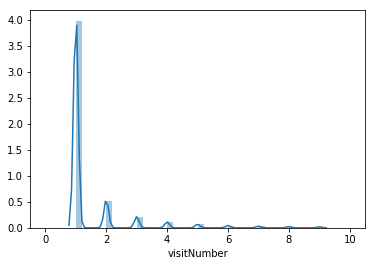

In [51]:
filtered = data_train['visitNumber'][data_train['visitNumber'] <10]
sns.distplot(filtered, hist_kws={"range": [0,10]}); # maybe catplot or boxplot ?

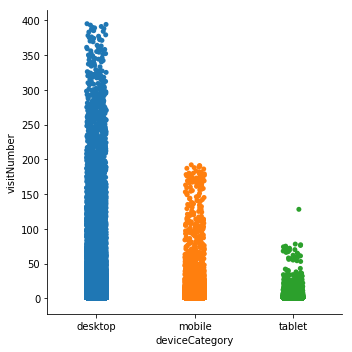

In [60]:
sns.catplot(x = 'deviceCategory', y = 'visitNumber', data=data_train)

In [61]:
data_train.describe(include=['object', 'bool'])

,channelGrouping,fullVisitorId,sessionId,browser,deviceCategory,isMobile,operatingSystem,city,continent,country,...,slot,targetingCriteria,campaign,keyword,medium,source,isTrueDirect,referralPath,adContent,campaignCode
count,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,...,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653
unique,8,714167,902755,54,3,2,20,649,6,222,...,3,2,10,3660,7,380,2,1476,45,2
top,Organic Search,1957458976293878100,6655979485478527103_1477465197,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,...,0,0,(not set),0,organic,google,0,0,0,0
freq,381561,278,2,620364,664479,664530,350072,508229,450377,364744,...,882193,902193,865347,502929,381561,400788,629648,572712,892707,903652


In [62]:
data_train['continent'].value_counts()

Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: continent, dtype: int64

In [64]:
data_train['country'].value_counts()

United States               364744
India                        51140
United Kingdom               37393
Canada                       25869
Vietnam                      24598
Turkey                       20522
Thailand                     20123
Germany                      19980
Brazil                       19783
Japan                        19731
France                       15832
Mexico                       13225
Taiwan                       12996
Australia                    12698
Russia                       11662
Spain                        11658
Netherlands                  11453
Italy                        11332
Poland                        9693
Indonesia                     9273
Philippines                   9244
Singapore                     7172
Ireland                       6493
Malaysia                      6439
Romania                       6428
Ukraine                       5577
Israel                        5563
Peru                          5546
Sweden              

In [67]:
data_train['city'].value_counts(normalize=True)

not available in demo dataset    0.562416
Mountain View                    0.045243
(not set)                        0.037915
New York                         0.029183
San Francisco                    0.022496
Sunnyvale                        0.014481
London                           0.013951
San Jose                         0.011393
Los Angeles                      0.009594
Bangkok                          0.008531
Chicago                          0.008238
Ho Chi Minh City                 0.008125
Istanbul                         0.007005
Bengaluru                        0.006051
Toronto                          0.005780
Hanoi                            0.005569
Seattle                          0.005561
Sydney                           0.005451
Dublin                           0.005397
Sao Paulo                        0.004544
Mumbai                           0.004536
Chennai                          0.004526
Paris                            0.004441
Hyderabad                        0

In [70]:
# Sorting by some value
data_train.sort_values(by='visitNumber', ascending=False).head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,...,slot,targetingCriteria,campaign,keyword,medium,source,isTrueDirect,referralPath,adContent,campaignCode
301285,Organic Search,20170723,0824839726118485274,0824839726118485274_1500835808,1500835808,395,1500835808,Chrome,desktop,False,...,0,0,(not set),(not provided),organic,google,True,0,0,0
772027,Organic Search,20170710,0824839726118485274,0824839726118485274_1499704723,1499704723,394,1499704723,Chrome,desktop,False,...,0,0,(not set),(not provided),organic,google,True,0,0,0
625963,Organic Search,20170707,0824839726118485274,0824839726118485274_1499434832,1499434832,393,1499434832,Chrome,desktop,False,...,0,0,(not set),(not provided),organic,google,True,0,0,0
455231,Organic Search,20170703,0824839726118485274,0824839726118485274_1499116090,1499116090,391,1499116090,Chrome,desktop,False,...,0,0,(not set),(not provided),organic,google,True,0,0,0
455084,Organic Search,20170703,0824839726118485274,0824839726118485274_1499111760,1499111760,390,1499111760,Chrome,desktop,False,...,0,0,(not set),(not provided),organic,google,True,0,0,0


In [76]:
data_train[data_train['date'].apply(lambda date: str(date)[5] == '3')].head() # shows only third month!

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,...,slot,targetingCriteria,campaign,keyword,medium,source,isTrueDirect,referralPath,adContent,campaignCode
6917,Organic Search,20170312,2547779995033004877,2547779995033004877_1489330147,1489330147,1,1489330147,Safari,mobile,True,...,0,0,(not set),(not provided),organic,google,0,0,0,0
6918,Organic Search,20170312,1226008528635272186,1226008528635272186_1489317226,1489317226,1,1489317226,Chrome,mobile,True,...,0,0,(not set),(not provided),organic,google,0,0,0,0
6919,Organic Search,20170312,5556377704337734794,5556377704337734794_1489311131,1489311131,1,1489311131,Chrome,desktop,False,...,0,0,(not set),(not provided),organic,google,0,0,0,0
6920,Direct,20170312,4766294151497305703,4766294151497305703_1489350290,1489350290,1,1489350290,Chrome,mobile,True,...,0,0,(not set),0,(none),(direct),True,0,0,0
6921,Organic Search,20170312,0874567061633260316,0874567061633260316_1489321974,1489321974,1,1489321974,Safari,tablet,True,...,0,0,(not set),(not provided),organic,google,0,0,0,0


In [80]:
data_train['date'].nunique()

366

### visitNumber vs transactionRevenue

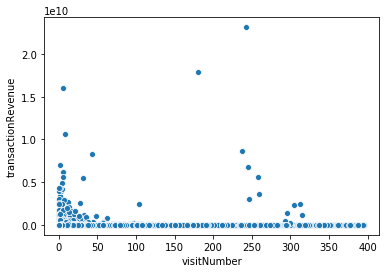

In [6]:
sns.scatterplot(x="visitNumber", y="transactionRevenue", data=data_train)

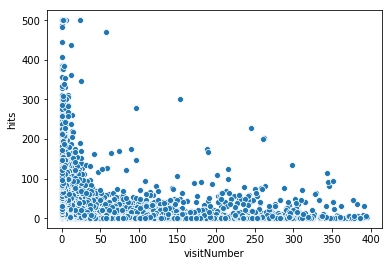

In [7]:
sns.scatterplot(x="visitNumber", y="hits", data=data_train)

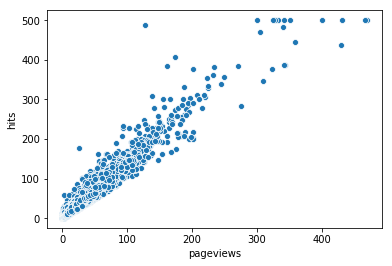

In [9]:
sns.scatterplot(x="pageviews", y="hits", data=data_train)

In [20]:
pd.crosstab(data_train['newVisits'], data_train['bounces'], normalize=True)

bounces,0.0,1.0
newVisits,,
0.0,0.127666,0.094314
1.0,0.373658,0.404362


In [27]:
# interesting trick
#np.r_[0:4, 6]

In [31]:
# Selecting a few columns
# float to int
data_train[['newVisits', 'bounces']] = data_train[['newVisits', 'bounces']].astype(int)